# ¿Cuanto dinero podemos ganar?

Para estimar la ganancia y optimizar la campaña, debemos combinar los resultados de la segmentación (Clustering) con los modelos de Propensión a Compra.

## Configuración inicial y librerías

In [1]:
# Basicos
import pandas as pd

# Para la visualizacion
import seaborn as sns
import matplotlib.pyplot as plt

# Para el modelo
import joblib
from sklearn.model_selection import train_test_split

# Para la evaluación del modelo
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve, auc

# Para la carga de datos
from os import path
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/data/TFM/'

Mounted at /content/drive


## Obtención de Datos

In [2]:
# datasets usado en el modelo de propension a compra de los clientes de 'sales'
df_final_xgb = pd.read_csv(path.join(base_path, 'clean_datasets', 'df_final_tarea2.csv'), index_col=0)

print(df_final_xgb.shape, '\n')
df_final_xgb.head(3)

(240773, 37) 



,pk_cid,active_customer,new_customer,pension_plan_purchase,long_term_deposit_purchase,short_term_deposit_purchase,recencia,short_term_deposit_lag1,loans_lag1,mortgage_lag1,...,region_code_costa,entry_channel_KFC,entry_channel_KHE,entry_channel_KHK,entry_channel_KHM,entry_channel_KHN,entry_channel_KHQ,entry_channel_OTHERS,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO
0,33620,1.0,0,False,False,True,1.302433,0.0,0.0,0.0,...,0,False,False,True,False,False,False,False,True,False
1,35063,1.0,0,False,False,True,1.055356,0.0,0.0,0.0,...,0,False,False,False,False,True,False,False,False,False
2,37299,1.0,0,False,False,True,1.302433,0.0,0.0,0.0,...,0,False,False,True,False,False,False,False,False,False


In [3]:
df_clustered = pd.read_csv(path.join(base_path, 'clean_datasets', 'df_clustered.csv'))

print(df_clustered.shape, '\n')
df_clustered.head(3)

(456172, 18) 



,pk_cid,months_in_company,gender,age,salary,n_orders,margin_gained,active_customer,total_items,channel_KAT,channel_KFC,channel_KHE,channel_KHK,channel_KHM,channel_KHN,channel_KHQ,channel_OTHERS,cluster
0,15891,2,0,59,176628.78,1,66.4,0.0,0,1,0,0,0,0,0,0,0,0
1,16063,7,0,62,163192.43,0,0.0,0.0,0,1,0,0,0,0,0,0,0,0
2,16203,6,1,70,152281.83,1,96.7,1.0,1,1,0,0,0,0,0,0,0,2


## Producto: Plan de Pensiones

In [4]:
# Cargamos el modelo pkl guardado con joblib.dump

model = joblib.load(path.join(base_path, 'models', 'model_pension_plan.pkl'))

Ya tenemos tanto modelo de propensión a compra como los distintos clusteres que creamos. El siguiente paso será elegir los clústeres objetivo.


*   Producto a ofrecer: Plan de Pensiones
*   Clústeres objetivo:
    * Cluster 2 (Leales y de Alto Valor): Son nuestra base más activa, y rentable, con historial de transacciones ideal para compromisos a largo plazo. El mensaje sería algo como "Asegura tu futuro con nosotros"
    * Clúster 3 (Potenciales de Alto Valor): Tienen alta capacidad de gasto, siendo el paso lógico un producto de inversión de alto margen. El mensaje debe ser: "Aprovecha tus ingresos para invertir."



In [5]:
target_clients = df_clustered[df_clustered['cluster'].isin([2, 3])].pk_cid
df_final = df_final_xgb[df_final_xgb['pk_cid'].isin(target_clients)].drop(columns=['pension_plan_purchase'])

print(f'Poblacion impactada: {df_final.shape[0]} clientes')
df_final.head(3)

Poblacion impactada: 131237 clientes


,pk_cid,active_customer,new_customer,long_term_deposit_purchase,short_term_deposit_purchase,recencia,short_term_deposit_lag1,loans_lag1,mortgage_lag1,funds_lag1,...,region_code_costa,entry_channel_KFC,entry_channel_KHE,entry_channel_KHK,entry_channel_KHM,entry_channel_KHN,entry_channel_KHQ,entry_channel_OTHERS,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO
2,37299,1.0,0,False,True,1.302433,0.0,0.0,0.0,0.0,...,0,False,False,True,False,False,False,False,False,False
3,39997,1.0,0,False,True,1.549510,0.0,0.0,0.0,0.0,...,0,False,False,False,False,False,False,False,True,False
4,44012,1.0,0,False,True,2.043664,0.0,0.0,0.0,0.0,...,0,False,False,False,False,False,False,True,True,False


In [6]:
predict_proba = model.predict_proba(df_final)

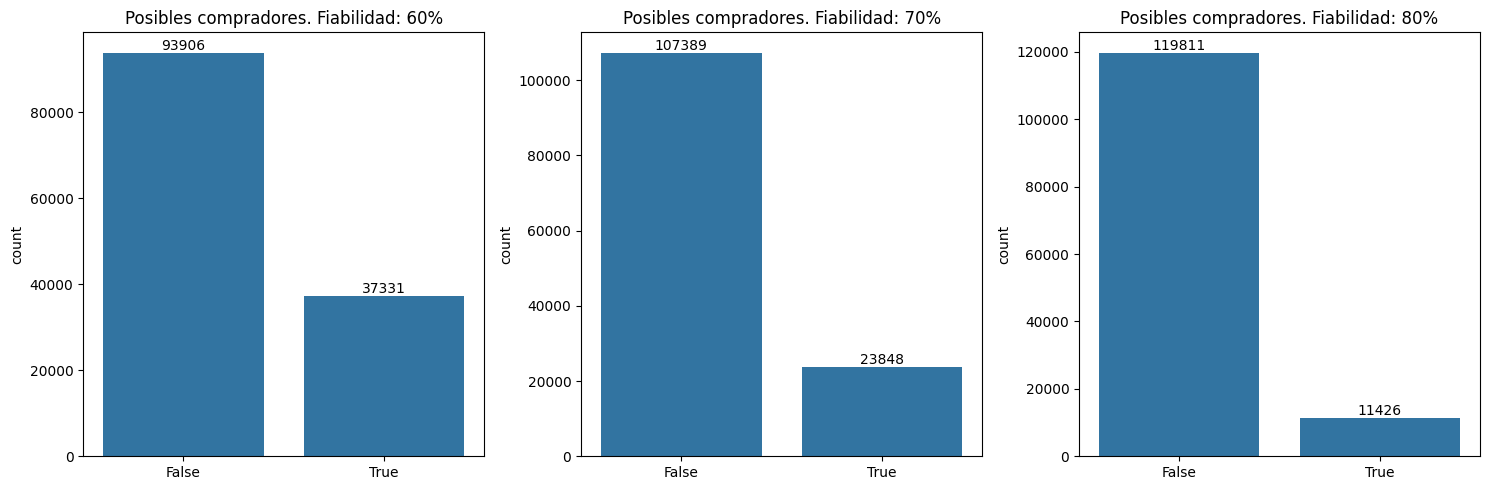

In [7]:
def add_count_annotations(plot):
    for container in plot.containers:
        plot.bar_label(container)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot for 60% threshold
ax_70 = sns.countplot(x=predict_proba[:, 1]>0.60, ax=axes[0])
axes[0].set_title('Posibles compradores. Fiabilidad: 60%')
add_count_annotations(ax_70)

# Plot for 70% threshold
ax_80 = sns.countplot(x=predict_proba[:, 1]>0.70, ax=axes[1])
axes[1].set_title('Posibles compradores. Fiabilidad: 70%')
add_count_annotations(ax_80)

# Plot for 80% threshold
ax_85 = sns.countplot(x=predict_proba[:, 1]>0.80, ax=axes[2])
axes[2].set_title('Posibles compradores. Fiabilidad: 80%')
add_count_annotations(ax_85)

plt.tight_layout()
plt.show()

Suponiendo los siguientes datos sobre la compañía:


*   Costo por Impacto: 20€ - costo estimado de contactar a un cliente (email, llamada, publicidad...)
*   Margen Neto Promedio: 5976€ - Margen neto que genera la venta de un Plan de Pensiones

Buscaremos el umbral de precisión que nos genere mayor ganancia

In [8]:
COSTO_IMPACTO = 20
MARGIN_NETO = 5976

# --- Escenario 1: Fiabilidad del 60% ---
n_impactados = 37330
n_compradores = n_impactados * 0.60
ganancia_60 = (n_compradores * MARGIN_NETO) - (n_impactados * COSTO_IMPACTO)
print(f"Ganancia con el 60%: {ganancia_60:,.0f}€")

# --- Escenario 2: Fiabilidad del 70% ---
n_impactados = 23847
n_compradores = n_impactados * 0.70
ganancia_70 = (n_compradores * MARGIN_NETO) - (n_impactados * COSTO_IMPACTO)
print(f"Ganancia con el 70%: {ganancia_70:,.0f}€")

# --- Escenario 3: Fiabilidad del 80% ---
n_impactados = 11425
n_compradores = n_impactados * 0.80
ganancia_80 = (n_compradores * MARGIN_NETO) - (n_impactados * COSTO_IMPACTO)
print(f"Ganancia con el 80%: {ganancia_80:,.0f}€")

# --- Escenario 4: Campaña tradicional ---
n_impactados = 131237
n_compradores = n_impactados * 0.08
ganancia_trad = (n_compradores * MARGIN_NETO) - (n_impactados * COSTO_IMPACTO)
print(f"\nGanancia con campaña tradicional: {ganancia_trad:,.0f}€")

Ganancia con el 60%: 133,103,848€
Ganancia con el 70%: 99,279,830€
Ganancia con el 80%: 54,392,140€

Ganancia con campaña tradicional: 60,117,045€


### Comparativa Campaña Tradicional VS Machine Learning
**Campaña Tradicional** -> 131,237 clientes impactados -> 8% Tasa de compra estimada -> 60M€ Ganancia Media Estimada
**Campaña Inteligente** -> 37,331 clientes impactados -> 60% Tasa de compra estimada -> 133M€ Ganancia Media Estimada

### Conclusion


Al focalizar nuestra campaña de pension_plan solo en los clústeres de alto valor y usando el modelo predictivo de XGBoost (Umbral 60%), estamos en capacidad de generar 133 Millones de Euros de ganancia neta, superando en más del doble la rentabilidad de una campaña masiva tradicional. Esto prueba la eficacia de la Inteligencia Artificial para la optimización de las ventas y el marketing.

## Producto: Depósito a Corto Plazo

In [9]:
# Cargamos el modelo pkl guardado con joblib.dump
model_short_term_deposit = joblib.load(path.join(base_path, 'models', 'model_short_term_deposit.pkl'))

Ya tenemos tanto modelo de propensión a compra como los distintos clusteres que creamos. El siguiente paso será elegir los clústeres objetivo.


*   Producto a ofrecer: Deposito a Corto Plazo
*   Clústeres objetivo:
    * Clúster 0 (Clientes Activos y Diversificados): Son altamente activos (56% activos) y tienen el mayor número de productos (total_items Media 38.01). Esto indica clientes con una relación bancaria compleja y necesidades de liquidez constantes, haciendo que un depósito a corto plazo sea un producto de gestión de liquidez muy atractivo."Mantén tu cartera diversificada y ágil: genera liquidez inmediata sin comprometer tu estrategia de inversión principal."
    * Clúster 2 (Clientes Leales de Alto Valor): Son la base más rentable, altamente activa (86% activos) y con el mayor número de órdenes (n_orders Media 1.23). Su alta lealtad y frecuencia de transacción hacen que sean el grupo con mayor confianza en la empresa y, por ende, más propensos a una compra bancaria, incluso si el producto es simple."Consolida tu confianza con el Depósito a Corto Plazo, una opción de liquidez premium diseñada para nuestros clientes más valiosos."


In [10]:
target_clients = df_clustered[df_clustered['cluster'].isin([0, 2])].pk_cid
df_final = df_final_xgb[df_final_xgb['pk_cid'].isin(target_clients)].drop(columns=['short_term_deposit_purchase'])

print(f'Poblacion impactada: {df_final.shape[0]} clientes')
df_final.head(3)

Poblacion impactada: 118814 clientes


,pk_cid,active_customer,new_customer,pension_plan_purchase,long_term_deposit_purchase,recencia,short_term_deposit_lag1,loans_lag1,mortgage_lag1,funds_lag1,...,region_code_costa,entry_channel_KFC,entry_channel_KHE,entry_channel_KHK,entry_channel_KHM,entry_channel_KHN,entry_channel_KHQ,entry_channel_OTHERS,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO
1,35063,1.0,0,False,False,1.055356,0.0,0.0,0.0,0.0,...,0,False,False,False,False,True,False,False,False,False
2,37299,1.0,0,False,False,1.302433,0.0,0.0,0.0,0.0,...,0,False,False,True,False,False,False,False,False,False
3,39997,1.0,0,False,False,1.549510,0.0,0.0,0.0,0.0,...,0,False,False,False,False,False,False,False,True,False


In [11]:
predict_proba = model_short_term_deposit.predict_proba(df_final)[:, 1]

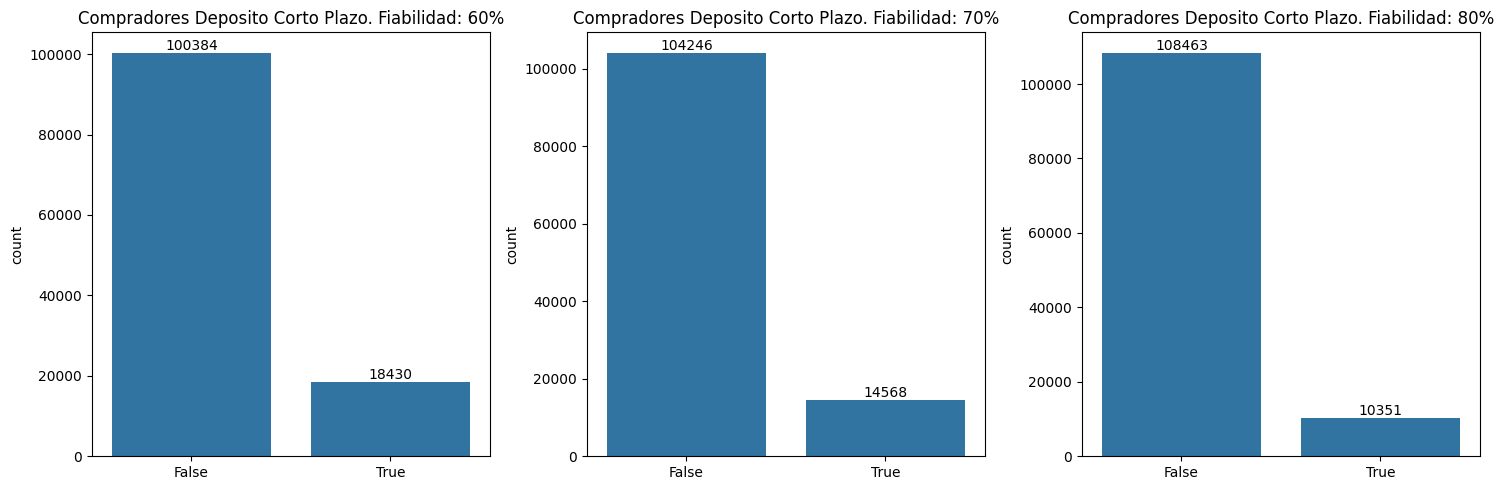

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot for 60% threshold
ax_70_std = sns.countplot(x=predict_proba > 0.60, ax=axes[0])
axes[0].set_title('Compradores Deposito Corto Plazo. Fiabilidad: 60%')
add_count_annotations(ax_70_std)

# Plot for 70% threshold
ax_80_std = sns.countplot(x=predict_proba > 0.70, ax=axes[1])
axes[1].set_title('Compradores Deposito Corto Plazo. Fiabilidad: 70%')
add_count_annotations(ax_80_std)

# Plot for 80% threshold
ax_85_std = sns.countplot(x=predict_proba > 0.80, ax=axes[2])
axes[2].set_title('Compradores Deposito Corto Plazo. Fiabilidad: 80%')
add_count_annotations(ax_85_std)

plt.tight_layout()
plt.show()

Suponiendo los siguientes datos sobre la compañía:


*   Costo por Impacto: 20€ - costo estimado de contactar a un cliente (email, llamada, publicidad...)
*   Margen neto Promedio: 1486€ - Margen neto que genera la venta de un Deposito a Corto Plazo

Buscaremos el umbral de precision que nos genere mayor ganancia




In [13]:
COSTO_IMPACTO = 20    # Costo por cliente impactado (€)
MARGIN_NETO = 1486    # Margen neto por Depósito a Corto Plazo (€)

# --- Escenario 1: Umbral de Probabilidad 70% ---
N_IMPACTADOS_60 = 18430
# Los compradores son el 60% de N_Impactados
N_COMPRADORES_60 = N_IMPACTADOS_60 * 0.60
GANANCIA_60 = (N_COMPRADORES_60 * MARGIN_NETO) - (N_IMPACTADOS_60 * COSTO_IMPACTO)
print(f"Ganancia con el 60%: {GANANCIA_60:,.0f}€")

# --- Escenario 2: Umbral de Probabilidad 70% ---
N_IMPACTADOS_70 = 14568
# Los compradores son el 70% de N_Impactados
N_COMPRADORES_70 = N_IMPACTADOS_70 * 0.70
GANANCIA_70 = (N_COMPRADORES_70 * MARGIN_NETO) - (N_IMPACTADOS_70 * COSTO_IMPACTO)
print(f"Ganancia con el 70%: {GANANCIA_70:,.0f}€")

# --- Escenario 3: Umbral de Probabilidad 80% ---
N_IMPACTADOS_80 = 10351
# Los compradores son el 80% de N_Impactados
N_COMPRADORES_80 = N_IMPACTADOS_80 * 0.80
GANANCIA_80 = (N_COMPRADORES_80 * MARGIN_NETO) - (N_IMPACTADOS_80 * COSTO_IMPACTO)
print(f"Ganancia con el 80%: {GANANCIA_80:,.0f}€")

# --- Escenario 4: Campaña tradicional ---
n_impactados = 118814
n_compradores = n_impactados * 0.018
ganancia_trad = (n_compradores * MARGIN_NETO) - (n_impactados * COSTO_IMPACTO)
print(f"\nGanancia con campaña tradicional: {ganancia_trad:,.0f}€")


Ganancia con el 60%: 16,063,588€
Ganancia con el 70%: 14,862,274€
Ganancia con el 80%: 12,098,249€

Ganancia con campaña tradicional: 801,757€


### Conclusión
El modelo de Depósito a Corto Plazo, pese a la baja propensión general en la población seleccionada, ofrece un retorno de la inversión extremadamente eficiente y seguro. A diferencia del Plan de Pensiones (focalizado en los clientes leales), esta campaña se orienta a adquirir y reactivar clientes de bajo compromiso (Cluster 1 y 5).

El Escenario 1 (Umbral 70%) es la opción recomendada. Con una inversión de solo 6,780€ (339 clientes x 20€), el modelo pronostica una ganancia neta de 295,472€.

El principal valor de este modelo no es solo la ganancia monetaria, sino la capacidad de reenganchar a clientes inactivos (Cluster 5) y convertir a clientes nuevos (Cluster 1) en futuros clientes de productos de mayor margen. La precisión del modelo garantiza que prácticamente no se desperdicia presupuesto en clientes que no comprarán.

### Comparativa Campaña tradicional VS Machine Learning

**Campaña Tradicional** -> 118814 clientes impactados -> 1.8% tasa de compra estimada ->  801,757€ Ganancia Neta Estimada

**Campaña Inteligente** -- 18430 clientes impactados -- 60% tasa de compra estimada -> 16,063,588€ Ganancia Neta Estimada

Para el Depósito a Corto Plazo, el modelo de Propensión junto con el clustering no solo optimiza, si no que transforma una campaña de 800mil Euros de ganancias en una campaña de  16M de Euros en ganancias

## Producto Depósito a Largo Plazo

In [14]:
# Cargamos el modelo pkl guardado con joblib.dump
model_long_term_deposit = joblib.load(path.join(base_path, 'models', 'model_long_term_deposit.pkl'))

El Depósito a Largo Plazo es un producto que requiere confianza, estabilidad financiera y una visión a futuro por parte del cliente. Por lo tanto, debemos enfocarnos en los clústeres con mayor antigüedad, rentabilidad y capacidad de ahorro

*   Producto a ofrecer: Deposito a Largo Plazo
*   Clústeres objetivo:
    * Cluster 2 (Clientes Leales y de Alto Valor): Son la base más rentable, activa, y con mayor número de órdenes. Muestran la lealtad y estabilidad necesarias para un compromiso a largo plazo.	"Maximiza tu lealtad: Asegura rendimientos superiores a largo plazo."
    * Clúster 4 (Clientes Pasivos pero de Alto Margen): Son inactivos, pero generan el mayor margen cuando compran. Suelen ser clientes con grandes transacciones esporádicas. Un depósito a largo plazo puede ser un destino ideal para su capital.	"Rentabiliza tu capital inmovilizado: Beneficios garantizados con la solidez de siempre."
    * Cluster 3 (Clientes Potenciales de Alto Valor): Tienen alto potencial (alto volumen de productos y buen margen). El depósito a largo plazo es el siguiente paso lógico para consolidar su relación con la empresa.	"Convierte tu potencial en seguridad financiera: El paso definitivo en tu inversión."

In [15]:
target_clients = df_clustered[df_clustered['cluster'].isin([2, 3, 4])].pk_cid
df_final = df_final_xgb[df_final_xgb['pk_cid'].isin(target_clients)].drop(columns=['long_term_deposit_purchase'])

print(f'Poblacion impactada: {df_final.shape[0]} clientes')
df_final.head(3)

Poblacion impactada: 191043 clientes


,pk_cid,active_customer,new_customer,pension_plan_purchase,short_term_deposit_purchase,recencia,short_term_deposit_lag1,loans_lag1,mortgage_lag1,funds_lag1,...,region_code_costa,entry_channel_KFC,entry_channel_KHE,entry_channel_KHK,entry_channel_KHM,entry_channel_KHN,entry_channel_KHQ,entry_channel_OTHERS,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO
0,33620,1.0,0,False,True,1.302433,0.0,0.0,0.0,0.0,...,0,False,False,True,False,False,False,False,True,False
2,37299,1.0,0,False,True,1.302433,0.0,0.0,0.0,0.0,...,0,False,False,True,False,False,False,False,False,False
3,39997,1.0,0,False,True,1.549510,0.0,0.0,0.0,0.0,...,0,False,False,False,False,False,False,False,True,False


In [16]:
predict_proba = model_long_term_deposit.predict_proba(df_final)[:, 1]

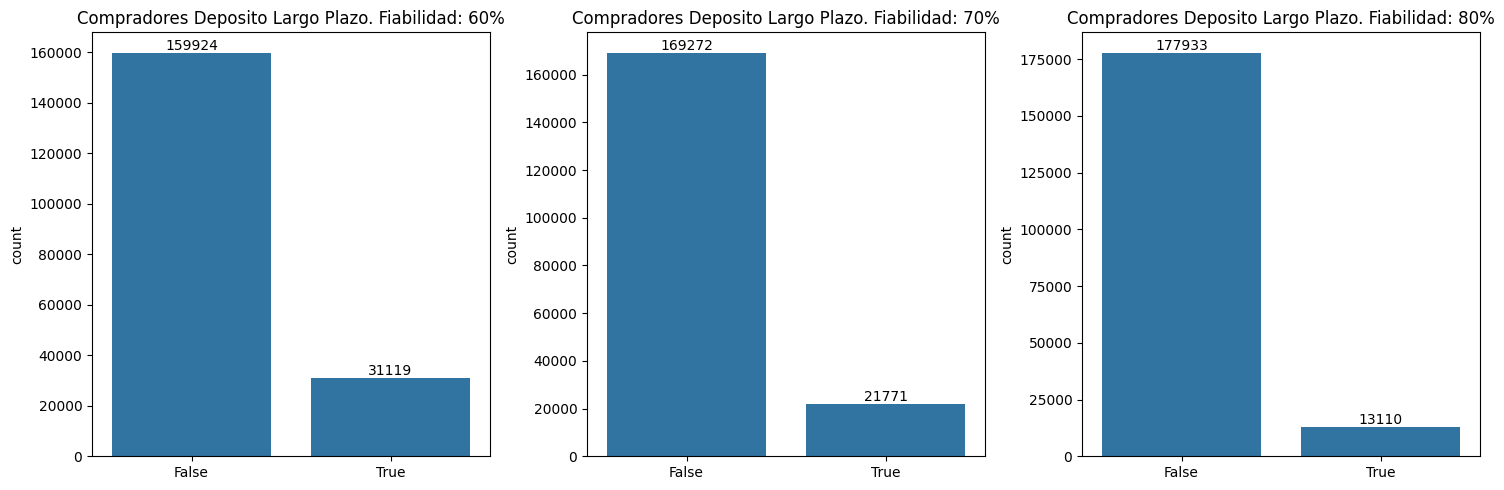

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot for 60% threshold
ax_60_std = sns.countplot(x=predict_proba > 0.60, ax=axes[0])
axes[0].set_title('Compradores Deposito Largo Plazo. Fiabilidad: 60%')
add_count_annotations(ax_60_std)

# Plot for 70% threshold
ax_70_std = sns.countplot(x=predict_proba > 0.70, ax=axes[1])
axes[1].set_title('Compradores Deposito Largo Plazo. Fiabilidad: 70%')
add_count_annotations(ax_70_std)

# Plot for 80% threshold
ax_80_std = sns.countplot(x=predict_proba > 0.80, ax=axes[2])
axes[2].set_title('Compradores Deposito Largo Plazo. Fiabilidad: 80%')
add_count_annotations(ax_80_std)

plt.tight_layout()
plt.show()

Suponiendo los siguientes datos sobre la compañía:


*   Costo por Impacto: 20€ - costo estimado de contactar a un cliente (email, llamada, publicidad...)
*   Margen neto Promedio: 1500€ - Margen neto que genera la venta de un Deposito a Corto Plazo

Buscaremos el umbral de precision que nos genere mayor ganancia


In [18]:
COSTO_IMPACTO = 20    # Costo por cliente impactado (€)
MARGIN_NETO = 1500    # Margen neto por Depósito a Largo Plazo (€)

# --- Escenario 1: Umbral de Probabilidad 60% ---
N_IMPACTADOS_60 = 31119
# Los compradores son el 60% de N_Impactados
N_COMPRADORES_60 = N_IMPACTADOS_60 * 0.60

GANANCIA_60 = (N_COMPRADORES_60 * MARGIN_NETO) - (N_IMPACTADOS_60 * COSTO_IMPACTO)
print(f"Ganancia con el 60%: {GANANCIA_60:,.0f}€")

# --- Escenario 2: Umbral de Probabilidad 70% ---
N_IMPACTADOS_70 = 21771
# Los compradores son el 70% de N_Impactados
N_COMPRADORES_70 = N_IMPACTADOS_70 * 0.70

GANANCIA_70 = (N_COMPRADORES_70 * MARGIN_NETO) - (N_IMPACTADOS_70 * COSTO_IMPACTO)
print(f"Ganancia con el 70%: {GANANCIA_70:,.0f}€")

# --- Escenario 3: Umbral de Probabilidad 80% ---
N_IMPACTADOS_80 = 13110
# Los compradores son el 80% de N_Impactados
N_COMPRADORES_80 = N_IMPACTADOS_80 * 0.80

GANANCIA_80 = (N_COMPRADORES_80 * MARGIN_NETO) - (N_IMPACTADOS_80 * COSTO_IMPACTO)
print(f"Ganancia con el 80%: {GANANCIA_80:,.0f}€")

# --- Escenario 4: Campaña tradicional ---
n_impactados = 191043
n_compradores = n_impactados * 0.0175
ganancia_trad = (n_compradores * MARGIN_NETO) - (n_impactados * COSTO_IMPACTO)
print(f"\nGanancia con campaña tradicional: {ganancia_trad:,.0f}€")

Ganancia con el 60%: 27,384,720€
Ganancia con el 70%: 22,424,130€
Ganancia con el 80%: 15,469,800€

Ganancia con campaña tradicional: 1,194,019€


### Conclusión

El modelo de Propensión a Compra garantiza que el Depósito a Largo Plazo se ofrezca solo a los clientes de mayor valor y estabilidad (C3, C4, C5), minimizando el riesgo de inversión.

### Comparativa Campaña tradicional VS Machine Learning

**Campaña Tradicional** -> 201,132 clientes impactados -> 1.75% tasa de compra estimada -> 1,19M€ Ganancia Neta Estimada

**Campaña Inteligente** -- 31,119 clientes impactados -- 60% tasa de compra estimada -> 27,28M€ Ganancia Neta Estimada

El modelo de Propensión a Compra incrementa la rentabilidad del Depósito a Largo Plazo en más de 20x (de 1.2 Millones de Euros a 27.3 Millones de Euros) al focalizar la inversión en los clientes Leales y de Alto Margen. Esto demuestra un retorno de la inversión masivo en los tres productos clave.